# Final Project

## Import Data

In [ ]:
import sklearn
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import matplotlib.pyplot as plt


import lightgbm as lgb
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer

In [ ]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')

In [ ]:
import re
app_train = app_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
app_test = app_test.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

## EDA

### Mengecek keseimbangan Label

In [ ]:
app_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

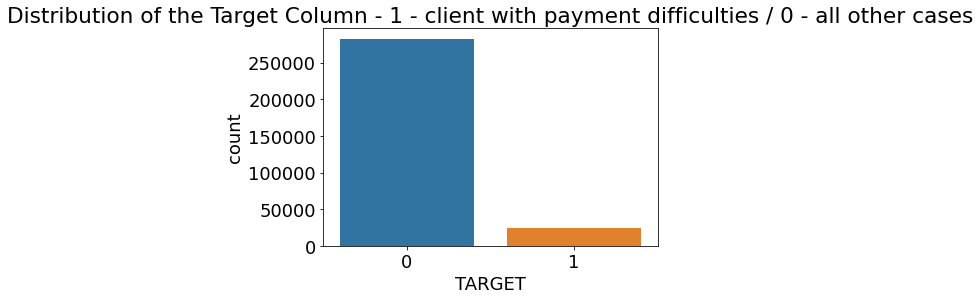

In [ ]:
plt.title('Distribution of the Target Column - 1 - client with payment difficulties / 0 - all other cases')
sns.countplot(x=app_train.TARGET, data=app_train)
plt.show()


Bisa dilihat bahwasanya kolom data tidak seimbang

In [ ]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

### Mengecek jumlah Missing Value

In [ ]:
# Function to calculate missing values by column# Funct // credits Will Koehrsen
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [ ]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(10)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


#### Drop Kolom dengan jumlah Missing Value tinggi

In [ ]:
# cols_to_drop = list((app_train.isnull().sum() > 75000).index)
cols_to_drop = [c for c in app_train.columns if app_train[c].isnull().sum() > 75000]

In [ ]:
app_train, app_test = app_train.drop(cols_to_drop, axis=1), app_test.drop(cols_to_drop, axis=1)
app_test.isnull().sum().sort_values(ascending=False).head(10)

EXT_SOURCE_3                  8668
AMT_REQ_CREDIT_BUREAU_YEAR    6049
AMT_REQ_CREDIT_BUREAU_QRT     6049
AMT_REQ_CREDIT_BUREAU_MON     6049
AMT_REQ_CREDIT_BUREAU_WEEK    6049
AMT_REQ_CREDIT_BUREAU_DAY     6049
AMT_REQ_CREDIT_BUREAU_HOUR    6049
NAME_TYPE_SUITE                911
DEF_60_CNT_SOCIAL_CIRCLE        29
OBS_30_CNT_SOCIAL_CIRCLE        29
dtype: int64

#### Imputasi

In [ ]:
app_train.select_dtypes(include=['O']).apply(pd.Series.nunique, axis=0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

In [ ]:
obj_cols = app_train.select_dtypes(include=['object']).columns
obj_cols

Index(['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'WEEKDAY_APPR_PROCESS_START',
       'ORGANIZATION_TYPE'],
      dtype='object')

In [ ]:
app_train[obj_cols] = app_train[obj_cols].fillna('Not specified')
app_test[obj_cols] = app_test[obj_cols].fillna('Not specified')

In [ ]:
float_cols = app_train.select_dtypes(include=['float']).columns
float_cols

Index(['AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       'REGION_POPULATION_RELATIVE', 'DAYS_REGISTRATION', 'CNT_FAM_MEMBERS',
       'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE',
       'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
       'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
       'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON',
       'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
      dtype='object')

In [ ]:
app_train[float_cols] = app_train[float_cols].fillna(app_train[float_cols].median())
app_test[float_cols] = app_test[float_cols].fillna(app_test[float_cols].median())

In [ ]:
app_train.shape, app_test.shape

((307511, 72), (48744, 71))

In [ ]:
app_train.duplicated().sum()


0

In [ ]:
app_test.duplicated().sum()

0

In [ ]:
# Number of unique classes in each object column
app_train.select_dtypes(include=['object']).apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                8
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
dtype: int64

### Mengubah data anomali

In [ ]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

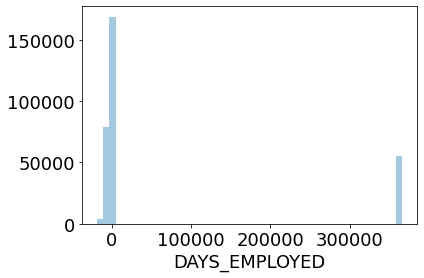

In [ ]:
sns.distplot(app_train['DAYS_EMPLOYED'], kde=False);
plt.show()

#### Mengisi nilai anomali dengan value Nan

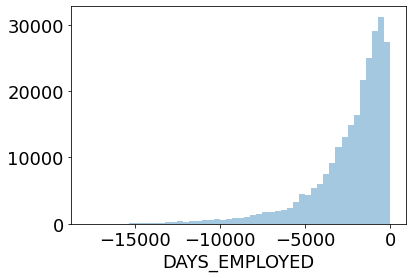

In [ ]:
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace=True)
sns.distplot(app_train['DAYS_EMPLOYED'].dropna(), kde=False);

In [ ]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace=True)

In [ ]:
print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Melihat Korelasi

In [ ]:
app_train[float_cols] = app_train[float_cols].apply(pd.to_numeric, errors='coerce')
app_train = app_train.fillna(app_train.median())

app_test[float_cols] = app_test[float_cols].apply(pd.to_numeric, errors='coerce')
app_test = app_train.fillna(app_test.median())

In [ ]:
correlations = app_train.corr()['TARGET'].sort_values()

print('Most Positive Correlations:\n', correlations.tail(10))
print('\n\nMost Negative Correlations:\n', correlations.head(10))

Most Positive Correlations:
 REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_EMPLOYED                  0.063368
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


Most Negative Correlations:
 EXT_SOURCE_2                 -0.160295
EXT_SOURCE_3                 -0.155892
DAYS_EMPLOYED_ANOM           -0.045987
AMT_GOODS_PRICE              -0.039623
REGION_POPULATION_RELATIVE   -0.037227
AMT_CREDIT                   -0.030369
FLAG_DOCUMENT_6              -0.028602
HOUR_APPR_PROCESS_START      -0.024166
FLAG_PHONE                   -0.023806
AMT_REQ_CREDIT_BUREAU_MON    -0.014794
Name: TARGET, dtype: float64


<AxesSubplot:>

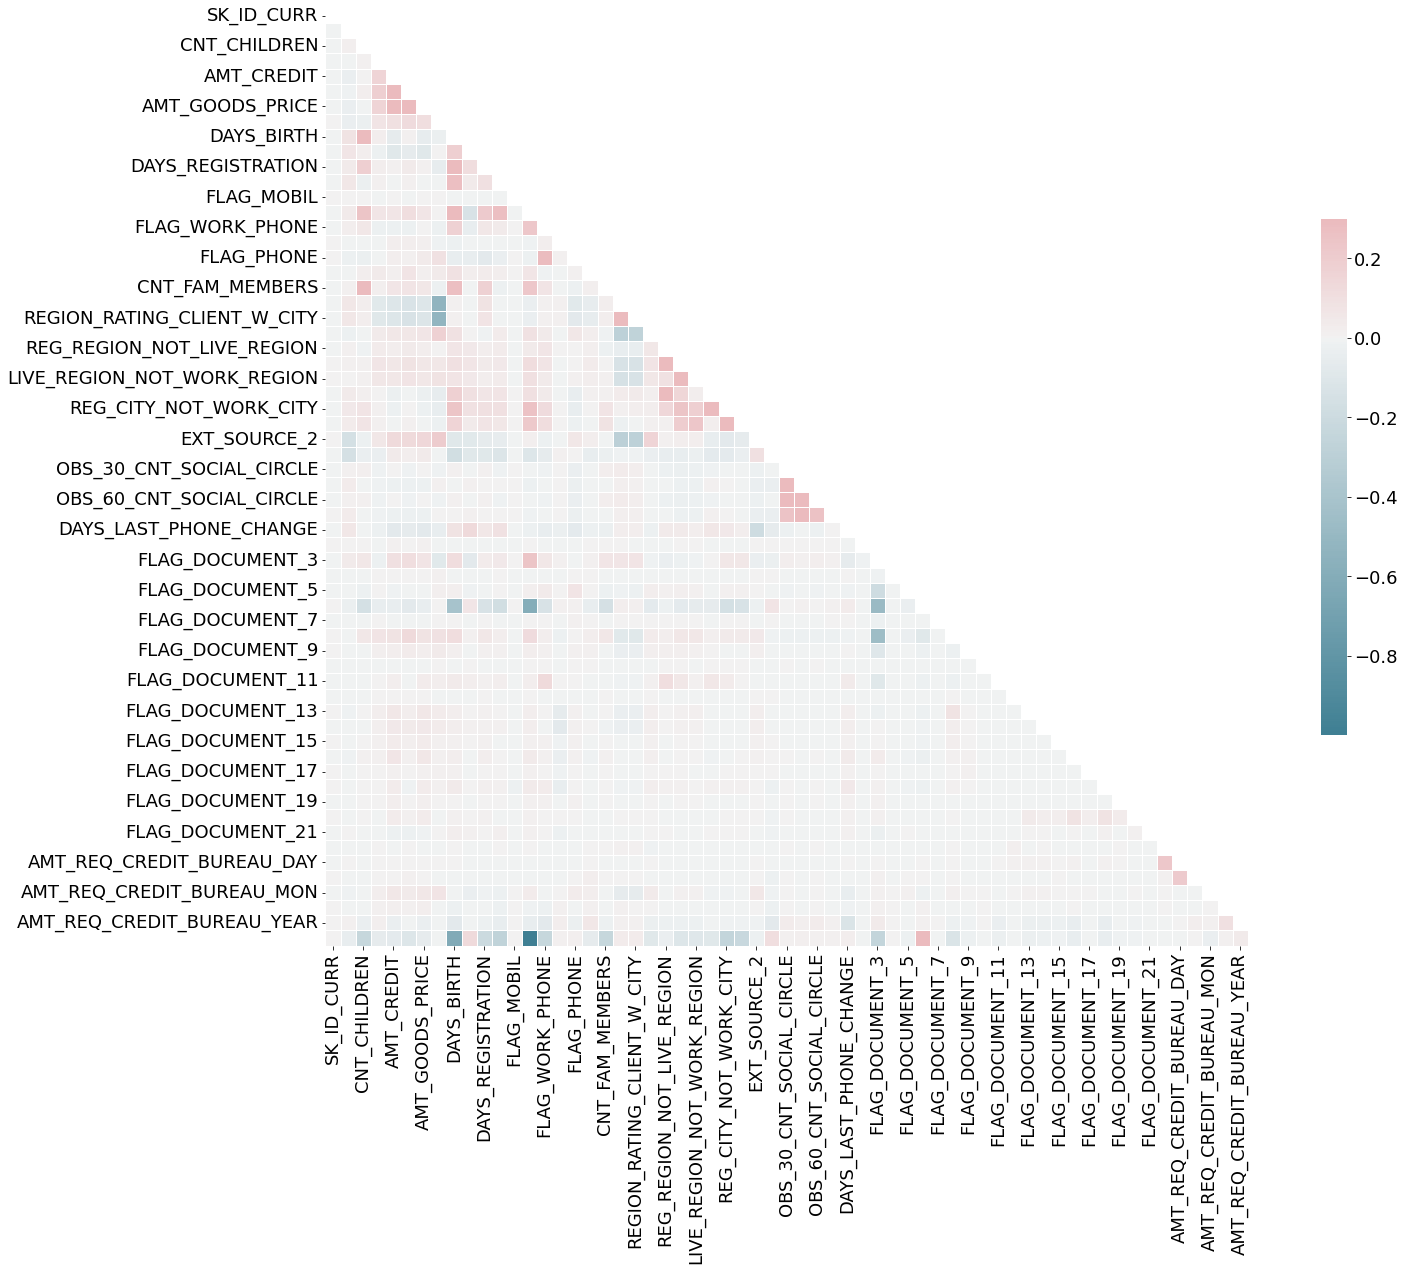

In [ ]:
# Compute the correlation matrix
corr = app_train.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(21, 19))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [ ]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982709

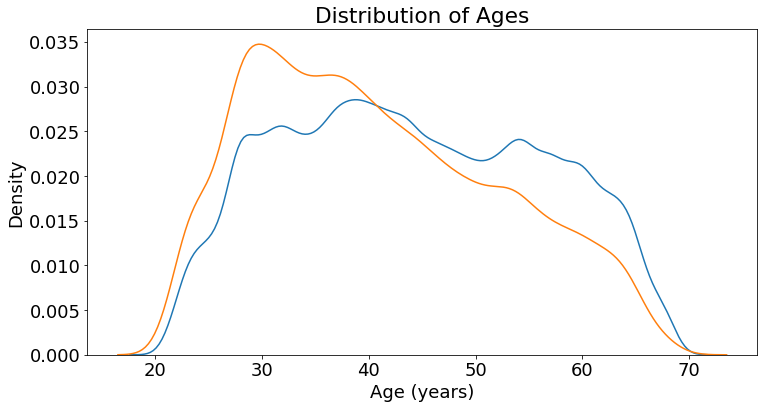

In [ ]:
plt.figure(figsize = (12, 6))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [ ]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [ ]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


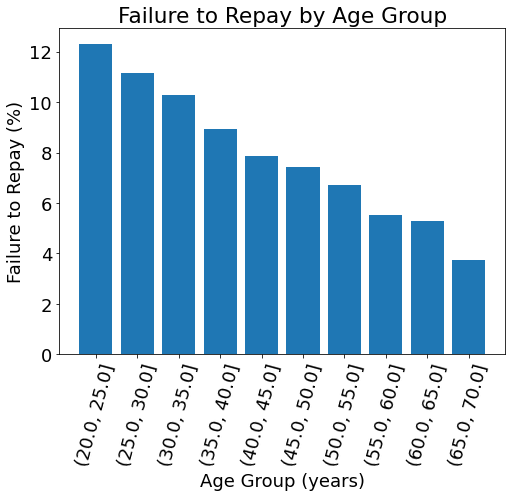

In [ ]:
plt.figure(figsize = (8, 6))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Age Group (years)'); plt.ylabel('Failure to Repay (%)')
plt.title('Failure to Repay by Age Group');

### Oversampling data

In [ ]:
## Cek perbandingan nilai
app_train['TARGET'].value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

In [ ]:
# Class count
count_class_0, count_class_1 = app_train['TARGET'].value_counts()

# Divide by class
df_class_0 = app_train[app_train['TARGET'] == 0]
df_class_1 = app_train[app_train['TARGET'] == 1]

Random over-sampling:
0    282686
1    282686
Name: TARGET, dtype: int64


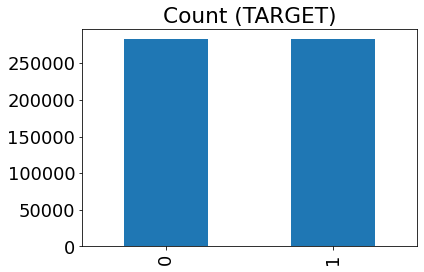

In [ ]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
app_train = pd.concat([df_class_0, df_class_1_over], axis=0)

print('Random over-sampling:')
print(app_train['TARGET'].value_counts())

app_train['TARGET'].value_counts().plot(kind='bar', title='Count (TARGET)');


In [ ]:
app_train['TARGET'].value_counts()

0    282686
1    282686
Name: TARGET, dtype: int64

### Feature Engineering - One Hot Encoding

In [ ]:
app_train = pd.get_dummies(data=app_train, columns=obj_cols)
app_test = pd.get_dummies(data=app_test, columns=obj_cols)

### Aligning Data

In [ ]:
y = app_train.TARGET
app_train = app_train.drop(['TARGET'], axis = 1)

In [ ]:
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

In [ ]:
app_train.shape, app_test.shape

((565372, 168), (307511, 168))

### StandarScaler/Normalisasi dan MinMaxScaller

In [ ]:
feat_to_scale = list(float_cols).copy()
feat_to_scale.extend(['CNT_CHILDREN', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'HOUR_APPR_PROCESS_START'])
feat_to_scale

['AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_REGISTRATION',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'CNT_CHILDREN',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_ID_PUBLISH',
 'HOUR_APPR_PROCESS_START']

In [ ]:
scaler = StandardScaler()
app_train[feat_to_scale] = scaler.fit_transform(app_train[feat_to_scale])
app_test[feat_to_scale] = scaler.fit_transform(app_test[feat_to_scale])
app_train.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,ORGANIZATION_TYPE_Trade: type 4,ORGANIZATION_TYPE_Trade: type 5,ORGANIZATION_TYPE_Trade: type 6,ORGANIZATION_TYPE_Trade: type 7,ORGANIZATION_TYPE_Transport: type 1,ORGANIZATION_TYPE_Transport: type 2,ORGANIZATION_TYPE_Transport: type 3,ORGANIZATION_TYPE_Transport: type 4,ORGANIZATION_TYPE_University,ORGANIZATION_TYPE_XNA
1,100003,-0.593204,0.187608,1.885066,0.652480,1.779773,-1.270927,0.289438,0.432541,1.039277,...,0,0,0,0,0,0,0,0,0,0
2,100004,-0.593204,-0.182379,-1.177223,-1.475016,-1.104842,-0.771684,0.816696,0.919845,0.143370,...,0,0,0,0,0,0,0,0,0,0
3,100006,-0.593204,-0.059050,-0.707552,0.210643,-0.634950,-0.926510,0.807219,-0.504115,-1.480862,...,0,0,0,0,0,0,0,0,0,0
4,100007,-0.593204,-0.083716,-0.178049,-0.364141,-0.008428,0.661284,1.021496,-0.503609,0.128506,...,0,0,0,0,0,0,0,0,0,0
5,100008,-0.593204,-0.124825,-0.237536,0.051238,-0.178111,1.209598,0.330121,0.230130,-0.063557,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Drop the target from the training data
if 'TARGET' in app_train:
    train = app_train.drop(columns=['TARGET'])
else:
    train = app_train.copy()

# Feature names
features = list(train.columns)

# Copy of the testing data
test = app_test.copy()

# Median imputation of missing values
imputer = SimpleImputer(strategy='median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(app_test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (565372, 168)
Testing data shape:  (307511, 168)


### Feature Selection dengan Mengukur Feature Importance Menggunakan Random Forest

In [ ]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)

In [ ]:
# Train on the training data
random_forest.fit(train, y)

# Extract feature importances
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': features, 'importance': feature_importance_values})

# Make predictions on the test data
predictions = random_forest.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   42.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.5s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.6s finished


In [ ]:
def plot_feature_importances(df, threshold=0.9):

    plt.rcParams['font.size'] = 18

    # Sort features according to importance
    df = df.sort_values('importance', ascending=False).reset_index()

    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize=(10, 6))
    ax = plt.subplot()

    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))),
            df['importance_normalized'].head(15),
            align='center', edgecolor='k')

    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))

    # Plot labeling
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importances')
    plt.show()

    # Cumulative importance plot
    plt.figure(figsize=(8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features')
    plt.ylabel('Cumulative Importance')
    plt.title('Cumulative Feature Importance')
    plt.show()

    importance_index = np.min(
        np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' %
          (importance_index + 1, threshold))

    return df

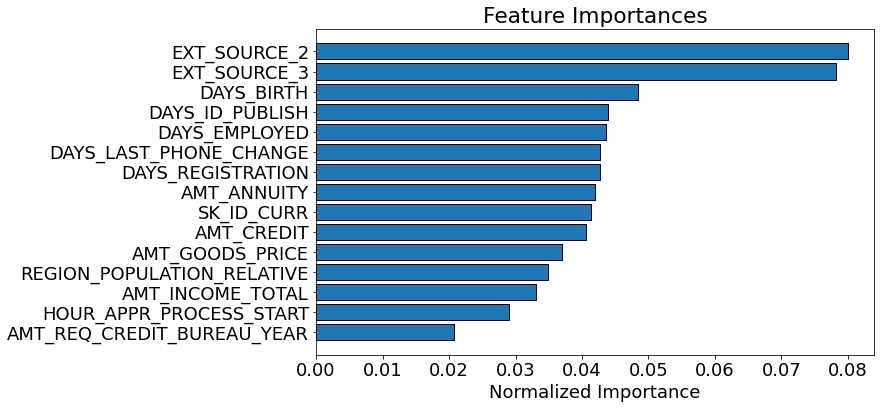

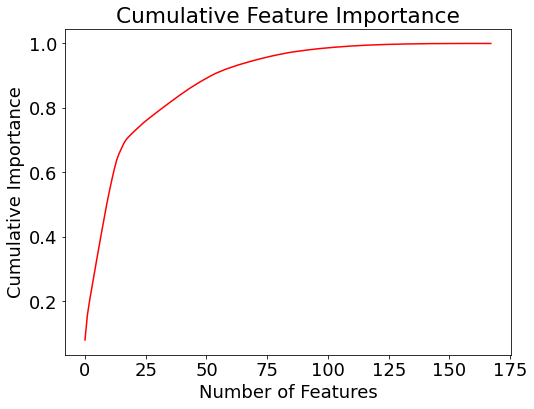

53 features required for 0.90 of cumulative importance


In [ ]:
# Show the feature importances for the default features
feature_importances_sorted = plot_feature_importances(feature_importances)

In [ ]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()

There are 1 features with 0.0 importance


,feature,importance
163,ORGANIZATION_TYPE_Transport: type 2,0.000633
164,ORGANIZATION_TYPE_Transport: type 3,0.000576
165,ORGANIZATION_TYPE_Transport: type 4,0.001510
166,ORGANIZATION_TYPE_University,0.000310
167,ORGANIZATION_TYPE_XNA,0.001390


In [ ]:
train = app_train.drop(columns=zero_features)
test = app_test.drop(columns=zero_features)

print('Training shape: ', train.shape)
print('Testing shape: ', test.shape)


Training shape:  (565372, 167)
Testing shape:  (307511, 167)


In [ ]:
# Threshold for cumulative importance
threshold = 0.95

# Extract the features to keep
features_to_keep = list(feature_importances_sorted[feature_importances_sorted['cumulative_importance'] < threshold]['feature'])

# Create new datasets with smaller features
train_small = train[features_to_keep]
test_small = test[features_to_keep]

### Choosing Certain Columns

In [ ]:
pd.set_option('display.max_rows', None)

In [ ]:
feature_importances.drop(feature_importances[feature_importances['importance'] == 0.0].index, inplace = True)
feature_importances.sort_values(by='importance', ascending=False)


,feature,importance
27,EXT_SOURCE_2,7.993449e-02
28,EXT_SOURCE_3,7.821749e-02
7,DAYS_BIRTH,4.841711e-02
10,DAYS_ID_PUBLISH,4.392162e-02
8,DAYS_EMPLOYED,4.356620e-02
33,DAYS_LAST_PHONE_CHANGE,4.268497e-02
9,DAYS_REGISTRATION,4.266943e-02
4,AMT_ANNUITY,4.194763e-02
0,SK_ID_CURR,4.137359e-02
3,AMT_CREDIT,4.054292e-02


In [ ]:
X_train_selected = app_train[['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
                        'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'AMT_ANNUITY',
                        'AMT_CREDIT', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'AMT_INCOME_TOTAL',
                        'HOUR_APPR_PROCESS_START', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
                        'CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'AMT_REQ_CREDIT_BUREAU_QRT',
                        'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'AMT_REQ_CREDIT_BUREAU_MON', 'FLAG_PHONE', 
                        'NAME_EDUCATION_TYPE_Secondary / secondary special',
                        'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Incomplete higher', 
                        'NAME_EDUCATION_TYPE_Lower secondary']]
Y_train_selected = y
test_selected = app_test[['EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
                          'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_LAST_PHONE_CHANGE', 'AMT_ANNUITY',
                          'AMT_CREDIT', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'AMT_INCOME_TOTAL',
                          'HOUR_APPR_PROCESS_START', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',
                          'CNT_FAM_MEMBERS', 'CNT_CHILDREN', 'AMT_REQ_CREDIT_BUREAU_QRT',
                          'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'AMT_REQ_CREDIT_BUREAU_MON', 'FLAG_PHONE', 
                          'NAME_EDUCATION_TYPE_Secondary / secondary special',
                          'NAME_EDUCATION_TYPE_Higher education', 'NAME_EDUCATION_TYPE_Academic degree', 'NAME_EDUCATION_TYPE_Incomplete higher', 
                          'NAME_EDUCATION_TYPE_Lower secondary']]


## Modelling

### All Column

In [ ]:
X = train_small

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C=0.0001)

# Train on the training data
log_reg.fit(X_train, y_train)


LogisticRegression(C=0.0001)

In [ ]:
#Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test_small)[:, 1]


In [ ]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

print(cross_val_score(log_reg, X_train, y_train, cv=3))


[0.65458611 0.65502577 0.65866434]


In [ ]:
# Save the submission to a csv file
submit.to_csv('baseline_LogisticRegression.csv', index=False)

#### Random Forest

In [ ]:
# Make the random forest classifier
random_forest = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)

In [ ]:
# Train on the training data
random_forest.fit(X_train, y_train)

# Make predictions on the test data
predictions = random_forest.predict_proba(test_small)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   23.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.4s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.6s finished


In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions

print(cross_val_score(random_forest, X_train, y_train, cv=3))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   19.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   13.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.4s
[Parallel(n

[0.98844754 0.98734839 0.98829594]


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished


In [ ]:
# Save the submission dataframe
submit.to_csv('random_forest_baseline.csv', index=False)

#### Light GBM

In [ ]:
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.fit_transform(X_test)

In [ ]:

model = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=22)

model.fit(X_train_scaled, y_train, eval_metric='auc', eval_set=[(X_train_scaled, y_train),(X_test_scaled, y_test)])

[1]	training's auc: 0.717641	training's binary_logloss: 0.679537	valid_1's auc: 0.713944	valid_1's binary_logloss: 0.679795
[2]	training's auc: 0.724033	training's binary_logloss: 0.66808	valid_1's auc: 0.719988	valid_1's binary_logloss: 0.668612
[3]	training's auc: 0.726344	training's binary_logloss: 0.658665	valid_1's auc: 0.722355	valid_1's binary_logloss: 0.659418
[4]	training's auc: 0.7278	training's binary_logloss: 0.650766	valid_1's auc: 0.72364	valid_1's binary_logloss: 0.651765
[5]	training's auc: 0.72997	training's binary_logloss: 0.643941	valid_1's auc: 0.725581	valid_1's binary_logloss: 0.645178
[6]	training's auc: 0.731444	training's binary_logloss: 0.638066	valid_1's auc: 0.727107	valid_1's binary_logloss: 0.639487
[7]	training's auc: 0.73261	training's binary_logloss: 0.633112	valid_1's auc: 0.728011	valid_1's binary_logloss: 0.634764
[8]	training's auc: 0.73371	training's binary_logloss: 0.628812	valid_1's auc: 0.729105	valid_1's binary_logloss: 0.630627
[9]	training's 

LGBMClassifier(class_weight='balanced', random_state=22)

In [ ]:
params = {
    'learning_rate': 0.2,
    'application': 'binary',
    'num_boost_round': 100,
    'nfold': 5,
    'num_leaves': 31,
    'verbosity': -1,
    'metric': 'auc',
    'data_random_seed': 2,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.6,
    'nthread': 4,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'early_stopping_rounds': 40,
}


def lightgbmcv(train, target, params):
    train_data = lgb.Dataset(train, label=target)
    model_lgbcv = lgb.cv(params, train_set=train_data)
    return model_lgbcv


model_cv = lightgbmcv(X_train_scaled, y_train, params=params)


In [ ]:
model_cv

{'auc-mean': [0.6812988823295136,
  0.6931876307272666,
  0.7018700152221028,
  0.7292318516044439,
  0.7384699655066408,
  0.738670955477971,
  0.7382564123584701,
  0.7421673476488866,
  0.7434911306359868,
  0.7457578244058091,
  0.7474103526108073,
  0.7496161615252881,
  0.7505174515616483,
  0.7518086375926148,
  0.7524053331307871,
  0.753585537952954,
  0.7545406004878611,
  0.7559021841009509,
  0.7568856225174367,
  0.7577031531385059,
  0.7585767372976764,
  0.7592721996598764,
  0.760074059827662,
  0.7610036276132008,
  0.7617935419337875,
  0.7623403938874946,
  0.7629035979820735,
  0.7635744436737919,
  0.7641720174827349,
  0.7648445697876024,
  0.7654538926056161,
  0.7659439041147664,
  0.7665264961174834,
  0.7671034094964526,
  0.7677599560274511,
  0.7686115175941834,
  0.769139424925077,
  0.7696110553833492,
  0.7701436114961793,
  0.7707611933532151,
  0.7712744854836113,
  0.7717590461088666,
  0.7721704513073071,
  0.7727550473200664,
  0.7731704854383473,
  

In [ ]:
predictions_model = model.predict_proba(test_small)[:, 1]


In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions_model
submit.to_csv('LGBMClassifier_baseline.csv', index=False)

### Feature Selected

In [ ]:
X = X_train_selected

X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_train_selected, Y_train_selected, test_size=0.3, random_state=42)


#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg_Sel = LogisticRegression(C=0.0001)

# Train on the training data
log_reg_Sel.fit(X_train_S, y_train_S)

LogisticRegression(C=0.0001)

In [ ]:
#Make predictions
# Make sure to select the second column only
log_reg_pred_Sel = log_reg_Sel.predict_proba(test_selected)[:, 1]


In [ ]:
# Submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred_Sel

submit.head()

print(cross_val_score(log_reg_Sel, X_train_S, y_train_S, cv=3))

[0.6656231  0.66426622 0.66748787]


In [ ]:
import joblib

In [ ]:
# Save the submission to a csv file
submit.to_csv('baseline_LogisticRegression_Selected.csv', index=False)
joblib.dump(submit, 'baseline_LogisticRegression_Selected.pkl')

['baseline_LogisticRegression_Selected.pkl']

#### Random Forest

In [ ]:
# Make the random forest classifier
random_forest_Sel = RandomForestClassifier(n_estimators=100, random_state=42, verbose=1, n_jobs=-1)

In [ ]:
# Train on the training data
random_forest_Sel.fit(X_train_S, y_train_S)

# Make predictions on the test data
predictions_Sel = random_forest_Sel.predict_proba(test_selected)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   18.0s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.3s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    1.1s finished


In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions_Sel

print(cross_val_score(random_forest_Sel, X_train_S, y_train_S, cv=3))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    7.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   15.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.2s
[Parallel(n

[0.98515767 0.98384627 0.98493784]


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.5s finished


In [ ]:
# Save the submission dataframe
submit.to_csv('random_forest_baseline_Selected.csv', index=False)
joblib.dump(submit, 'random_forest_baseline_Selected.pkl')

['random_forest_baseline_Selected.pkl']

#### Light GBM

In [ ]:
min_max_scaler = MinMaxScaler()
X_train_scaled_S = min_max_scaler.fit_transform(X_train_S)
X_test_scaled_S = min_max_scaler.fit_transform(X_test_S)

In [ ]:
model_Sel = lgb.LGBMClassifier(n_estimators=100, class_weight='balanced', random_state=22)

model_Sel.fit(X_train_scaled_S, y_train_S, eval_metric='auc', eval_set=[(X_train_scaled_S, y_train_S),(X_test_scaled_S, y_test_S)])

[1]	training's auc: 0.716569	training's binary_logloss: 0.679661	valid_1's auc: 0.713798	valid_1's binary_logloss: 0.679806
[2]	training's auc: 0.721137	training's binary_logloss: 0.668561	valid_1's auc: 0.718158	valid_1's binary_logloss: 0.668907
[3]	training's auc: 0.723655	training's binary_logloss: 0.659194	valid_1's auc: 0.720699	valid_1's binary_logloss: 0.659653
[4]	training's auc: 0.725395	training's binary_logloss: 0.651385	valid_1's auc: 0.722244	valid_1's binary_logloss: 0.652016
[5]	training's auc: 0.72672	training's binary_logloss: 0.644826	valid_1's auc: 0.723468	valid_1's binary_logloss: 0.645634
[6]	training's auc: 0.72781	training's binary_logloss: 0.639225	valid_1's auc: 0.724486	valid_1's binary_logloss: 0.640199
[7]	training's auc: 0.728947	training's binary_logloss: 0.634409	valid_1's auc: 0.72553	valid_1's binary_logloss: 0.635522
[8]	training's auc: 0.72974	training's binary_logloss: 0.63029	valid_1's auc: 0.726127	valid_1's binary_logloss: 0.631621
[9]	training'

LGBMClassifier(class_weight='balanced', random_state=22)

In [ ]:
params = {
    'learning_rate': 0.2,
    'application': 'binary',
    'num_boost_round': 100,
    'nfold': 5,
    'num_leaves': 31,
    'verbosity': -1,
    'metric': 'auc',
    'data_random_seed': 2,
    'bagging_fraction': 0.8,
    'feature_fraction': 0.6,
    'nthread': 4,
    'lambda_l1': 1,
    'lambda_l2': 1,
    'early_stopping_rounds': 40,
}


def lightgbmcvS(train, target, params):
    train_data = lgb.Dataset(train, label=target)
    model_lgbcv = lgb.cv(params, train_set=train_data)
    return model_lgbcv


model_cv_S = lightgbmcvS(X_train_scaled_S, y_train_S, params=params)

In [ ]:
model_cv_S

{'auc-mean': [0.6851357174562429,
  0.7228718609625095,
  0.7320578941034356,
  0.7327638351874702,
  0.7338603177522032,
  0.7343593163404836,
  0.7353255891494357,
  0.736007647795953,
  0.7387052302502181,
  0.7399537123808217,
  0.7411075616123822,
  0.7420930332162545,
  0.7429956908417137,
  0.7441568617832619,
  0.744891800675544,
  0.7461930995889234,
  0.7467772131144639,
  0.7484088677697909,
  0.749147608074926,
  0.7498275885857982,
  0.7504469794658883,
  0.7515687197195493,
  0.7522003175146359,
  0.7528543539252315,
  0.7534939888931735,
  0.754354902229711,
  0.7549824250943052,
  0.7557070596295772,
  0.7563310676238644,
  0.7569805132888175,
  0.7575584777704132,
  0.7580670395232526,
  0.7584869014288818,
  0.7590469598127129,
  0.7596578506976285,
  0.7602359047555453,
  0.760660266042432,
  0.7611203775301316,
  0.7615832835734303,
  0.7620781898648221,
  0.7625732940797836,
  0.7631426210411213,
  0.7637018693424065,
  0.7641337393456761,
  0.7646401737376023,
  0

In [ ]:
predictions_model_S = model_Sel.predict_proba(test_selected)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions_model_S
submit.to_csv('LGBMClassifier_baseline_Selected.csv', index=False)
joblib.dump(submit, 'LGBMClassifier_baseline_Selected.pkl')


['LGBMClassifier_baseline_Selected.pkl']

## Evaluation

### ROC Curve

#### All Columns

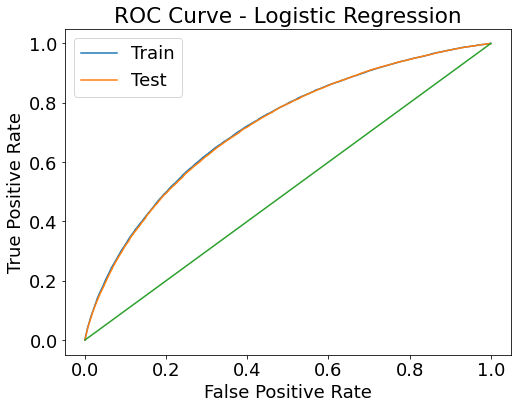

In [ ]:
#Logistic Regression


prob_train = log_reg.predict_proba(X_train_scaled)
prob_test = log_reg.predict_proba(X_test_scaled)

# Create train and test curve
fpr_train, tpr_train, thresh_train = roc_curve(y_train, prob_train[:, 1])
fpr_test, tpr_test, thresh_test = roc_curve(y_test, prob_test[:, 1])

# Create the straight line (how the graph looks like if the model does random guess instead)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

# Plot the model
plt.figure(figsize=(8, 6))
plt.title('ROC Curve - Logistic Regression')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot(p_fpr, p_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.3s finished


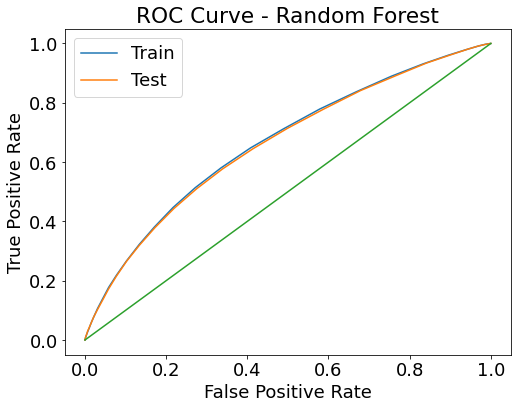

In [ ]:
#Random Forest


prob_train = random_forest.predict_proba(X_train_scaled)
prob_test = random_forest.predict_proba(X_test_scaled)

# Create train and test curve
fpr_train, tpr_train, thresh_train = roc_curve(y_train, prob_train[:, 1])
fpr_test, tpr_test, thresh_test = roc_curve(y_test, prob_test[:, 1])

# Create the straight line (how the graph looks like if the model does random guess instead)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

# Plot the model
plt.figure(figsize=(8, 6))
plt.title('ROC Curve - Random Forest')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot(p_fpr, p_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

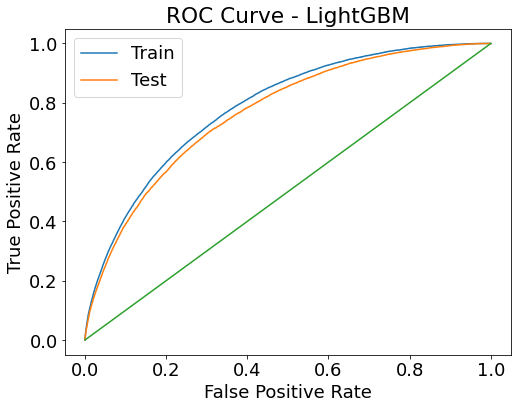

In [ ]:
#LIGHT GBM


prob_train = model.predict_proba(X_train_scaled)
prob_test = model.predict_proba(X_test_scaled)

# Create train and test curve
fpr_train, tpr_train, thresh_train = roc_curve(y_train, prob_train[:, 1])
fpr_test, tpr_test, thresh_test = roc_curve(y_test, prob_test[:, 1])

# Create the straight line (how the graph looks like if the model does random guess instead)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

# Plot the model
plt.figure(figsize=(8, 6))
plt.title('ROC Curve - LightGBM')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot(p_fpr, p_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

#### Feature Selected

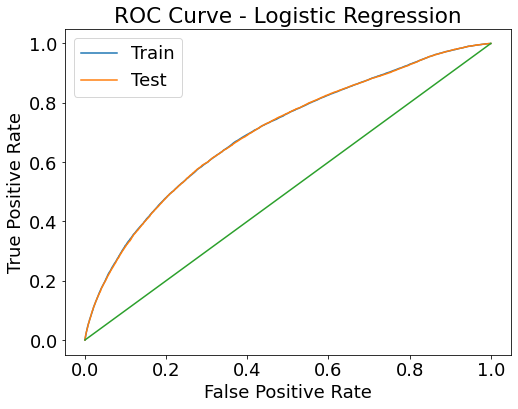

In [ ]:
#Logistic Regression


prob_train = log_reg_Sel.predict_proba(X_train_scaled_S)
prob_test = log_reg_Sel.predict_proba(X_test_scaled_S)

# Create train and test curve
fpr_train, tpr_train, thresh_train = roc_curve(y_train_S, prob_train[:, 1])
fpr_test, tpr_test, thresh_test = roc_curve(y_test_S, prob_test[:, 1])

# Create the straight line (how the graph looks like if the model does random guess instead)
random_probs = [0 for i in range(len(y_test_S))]
p_fpr, p_tpr, _ = roc_curve(y_test_S, random_probs)

# Plot the model
plt.figure(figsize=(8, 6))
plt.title('ROC Curve - Logistic Regression')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot(p_fpr, p_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.2s finished


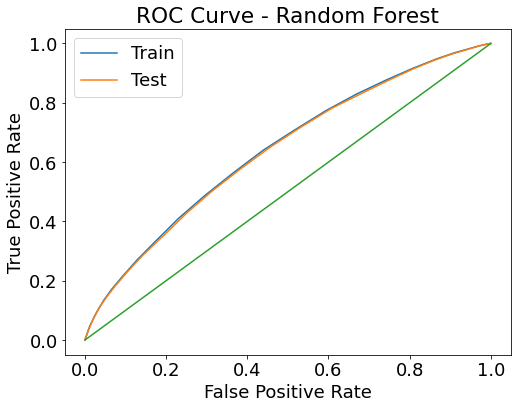

In [ ]:
#Random Forest


prob_train = random_forest_Sel.predict_proba(X_train_scaled_S)
prob_test = random_forest_Sel.predict_proba(X_test_scaled_S)

# Create train and test curve
fpr_train, tpr_train, thresh_train = roc_curve(y_train_S, prob_train[:, 1])
fpr_test, tpr_test, thresh_test = roc_curve(y_test_S, prob_test[:, 1])

# Create the straight line (how the graph looks like if the model does random guess instead)
random_probs = [0 for i in range(len(y_test_S))]
p_fpr, p_tpr, _ = roc_curve(y_test_S, random_probs)

# Plot the model
plt.figure(figsize=(8, 6))
plt.title('ROC Curve - Random Forest')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot(p_fpr, p_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

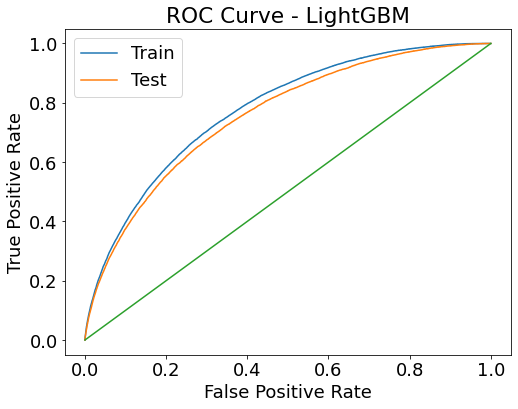

In [ ]:
#LIGHT GBM


prob_train = model_Sel.predict_proba(X_train_scaled_S)
prob_test = model_Sel.predict_proba(X_test_scaled_S)

# Create train and test curve
fpr_train, tpr_train, thresh_train = roc_curve(y_train_S, prob_train[:, 1])
fpr_test, tpr_test, thresh_test = roc_curve(y_test_S, prob_test[:, 1])

# Create the straight line (how the graph looks like if the model does random guess instead)
random_probs = [0 for i in range(len(y_test_S))]
p_fpr, p_tpr, _ = roc_curve(y_test_S, random_probs)

# Plot the model
plt.figure(figsize=(8, 6))
plt.title('ROC Curve - LightGBM')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot(p_fpr, p_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()


### Confusion Matrix

#### All Column

In [ ]:
y_lr = log_reg.predict(X_test)
y_rndm = random_forest.predict(X_test)
y_lgb = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix

cf_logReg = confusion_matrix(y_test, y_lr)
cf_RandFor = confusion_matrix(y_test, y_rndm)
cf_lgb = confusion_matrix(y_test, y_lgb)

print(cf_logReg)
print(cf_RandFor)
print(cf_lgb)


[[53709 31126]
 [27418 57359]]
[[84334   501]
 [   43 84734]]
[[62789 22046]
 [44323 40454]]


<AxesSubplot:>

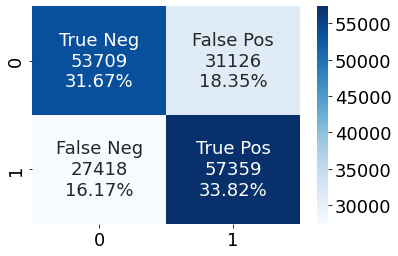

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_logReg.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_logReg.flatten()/np.sum(cf_logReg)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_logReg, annot=labels, fmt='', cmap='Blues')

<AxesSubplot:>

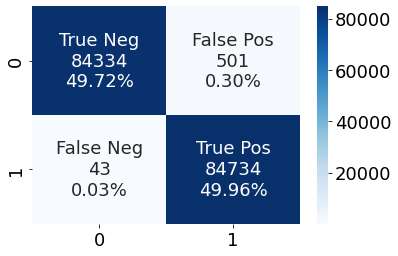

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_RandFor.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_RandFor.flatten()/np.sum(cf_RandFor)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_RandFor, annot=labels, fmt='', cmap='Blues')

<AxesSubplot:>

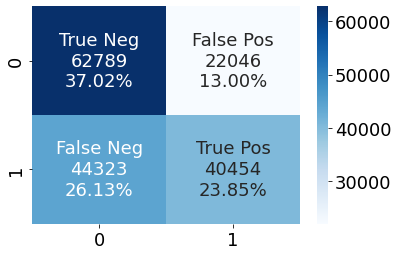

In [ ]:
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_lgb.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_lgb.flatten()/np.sum(cf_lgb)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_lgb, annot=labels, fmt='', cmap='Blues')


#### Feature Selected

In [ ]:
y_lr_Sel = log_reg_Sel.predict(X_test_S)
y_rndm_Sel = random_forest_Sel.predict(X_test_S)
y_lgb_Sel = model_Sel.predict(X_test_S)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.9s finished


In [ ]:
from sklearn.metrics import confusion_matrix

cf_logReg_Sel = confusion_matrix(y_test_S, y_lr_Sel)
cf_RandFor_Sel = confusion_matrix(y_test_S, y_rndm_Sel)
cf_lgb_Sel = confusion_matrix(y_test_S, y_lgb_Sel)

print(cf_logReg_Sel)
print(cf_RandFor_Sel)
print(cf_lgb_Sel)

[[57273 27562]
 [29073 55704]]
[[84055   780]
 [   40 84737]]
[[55577 29258]
 [36752 48025]]


<AxesSubplot:>

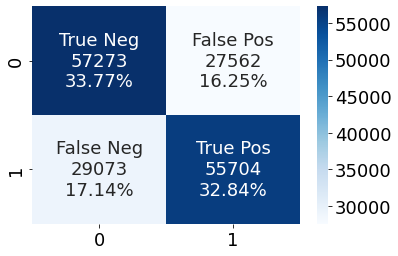

In [ ]:
# Heatmap Logistic Regression

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_logReg_Sel.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_logReg_Sel.flatten()/np.sum(cf_logReg_Sel)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_logReg_Sel, annot=labels, fmt='', cmap='Blues')

<AxesSubplot:>

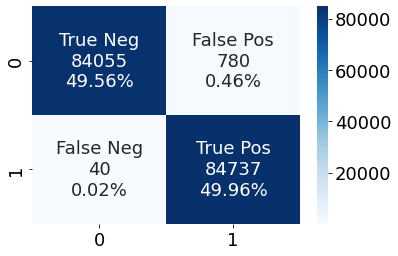

In [ ]:
# Heatmap Random Forest

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_RandFor_Sel.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_RandFor_Sel.flatten()/np.sum(cf_RandFor_Sel)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_RandFor_Sel, annot=labels, fmt='', cmap='Blues')

<AxesSubplot:>

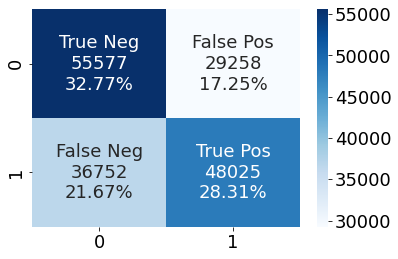

In [ ]:
# Heatmap Light GBM

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_lgb_Sel.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_lgb_Sel.flatten()/np.sum(cf_lgb_Sel)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_lgb_Sel, annot=labels, fmt='', cmap='Blues')

## Hyperpatameter Tuning + Evaluation

### All Columns

In [ ]:
X = train_small
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [ ]:
min_max_scaler = MinMaxScaler()
X_train_scaled = min_max_scaler.fit_transform(X_train)
X_test_scaled = min_max_scaler.fit_transform(X_test)

#### Grid Search

In [ ]:
rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2, 3, 5, 10],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'n_estimators': [10, 25, 30, 50, 100]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf_grid,
                           param_grid=params,
                           cv=3,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 25, 30, 50, 100]},
             scoring='accuracy', verbose=1)

In [ ]:
grid_search.best_score_

0.7179108032705311

In [ ]:
rf_grid_best = grid_search.best_estimator_
rf_grid_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

<AxesSubplot:>

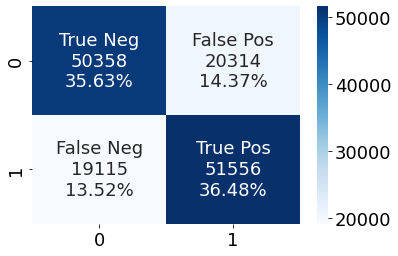

In [ ]:
y_lgb = rf_grid_best.predict(X_test)
cf_grid = confusion_matrix(y_test, y_lgb)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_grid.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_grid.flatten()/np.sum(cf_grid)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_grid, annot=labels, fmt='', cmap='Blues')

In [ ]:
predictions_grid = rf_grid_best.predict_proba(test_small)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions_grid
submit.to_csv('random_forest_GridSearch_baseline.csv', index=False)

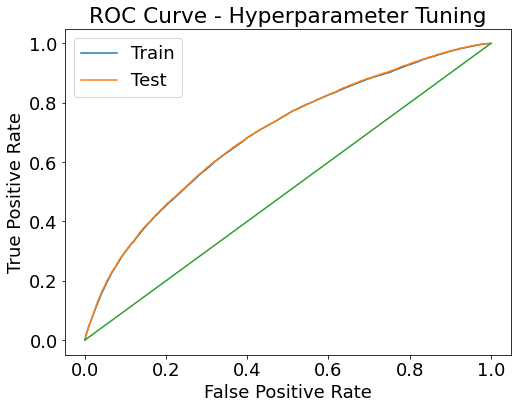

In [ ]:
#Tuning - Grid Search 


prob_train = rf_grid_best.predict_proba(X_train_scaled)
prob_test = rf_grid_best.predict_proba(X_test_scaled)

# Create train and test curve
fpr_train, tpr_train, thresh_train = roc_curve(y_train, prob_train[:, 1])
fpr_test, tpr_test, thresh_test = roc_curve(y_test, prob_test[:, 1])

# Create the straight line (how the graph looks like if the model does random guess instead)
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs)

# Plot the model
plt.figure(figsize=(8, 6))
plt.title('ROC Curve - Hyperparameter Tuning')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot(p_fpr, p_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()


#### Bayesian Optimization

In [ ]:
# # Create the optimizer. The black box function to optimize is not
# # specified here, as we will call that function directly later on.

# import matplotlib.pyplot as plt
# from bayes_opt import BayesianOptimization, UtilityFunction
# from sklearn.svm import SVC

# optimizer = BayesianOptimization(f=None,
#                                  pbounds={"C": [0.01, 10],"degree": [1, 5]},
#                                  verbose=2, 
#                                  random_state=1234)
# # Specify the acquisition function (bayes_opt uses the term
# # utility function) to be the upper confidence bounds "ucb".
# # We set kappa = 1.96 to balance exploration vs exploitation.
# # xi = 0.01 is another hyper parameter which is required in the
# # arguments, but is not used by "ucb". Other acquisition functions
# # such as the expected improvement "ei" will be affected by xi.
# utility = UtilityFunction(kind="ucb", kappa=1.96, xi=0.01)
# # We want to optimize both C and degree simultaneously.


# def black_box_function(C, degree):
#     model_bayes = SVC(C=C, degree=degree)
#     model_bayes.fit(X_train_scaled, y_train)
#     y_score = model.decision_function(X_test_scaled)
#     f = roc_auc_score(y_test, y_score)
#     return f


# # Optimization for loop.
# for i in range(25):
#     # Get optimizer to suggest new parameter values to try using the
#     # specified acquisition function.
#     next_point = optimizer.suggest(utility)
#     # Force degree from float to int.
#     next_point["degree"] = int(next_point["degree"])
#     # Evaluate the output of the black_box_function using
#     # the new parameter values.
#     target = black_box_function(**next_point)
#     try:
#         # Update the optimizer with the evaluation results.
#         # This should be in try-except to catch any errors!
#         optimizer.register(params=next_point, target=target)
#     except:
#         pass
# print("Best result: {}; f(x) = {:.3f}.".format(optimizer.max["params"], optimizer.max["target"]))
# plt.figure(figsize=(15, 5))
# plt.plot(range(1, 1 + len(optimizer.space.target)),optimizer.space.target, "-o")
# plt.grid(True)
# plt.xlabel("Iteration", fontsize=14)
# plt.ylabel("Black box function f(x)", fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()

### Feature Selected

In [ ]:
X = X_train_selected
X_train_S, X_test_S, y_train_S, y_test_S = train_test_split(X_train_selected, Y_train_selected, stratify=y, random_state=42)


In [ ]:
min_max_scaler = MinMaxScaler()
X_train_scaled_Sel = min_max_scaler.fit_transform(X_train_S)
X_test_scaled_Sel = min_max_scaler.fit_transform(X_test_S)

#### Grid Search

In [ ]:
rf_grid = RandomForestClassifier(random_state=42, n_jobs=-1)
params = {
    'max_depth': [2, 3, 5, 10],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'n_estimators': [10, 25, 30, 50, 100]
}

In [ ]:
from sklearn.model_selection import GridSearchCV

# Instantiate the grid search model
grid_search_S = GridSearchCV(estimator=rf_grid,
                           param_grid=params,
                           cv=3,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search_S.fit(X_train_scaled_Sel, y_train_S)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=3, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10],
                         'min_samples_leaf': [5, 10, 20, 50, 100],
                         'n_estimators': [10, 25, 30, 50, 100]},
             scoring='accuracy', verbose=1)

In [ ]:
grid_search_S.best_score_

0.709347709708534

In [ ]:
rf_grid_best_Sel = grid_search_S.best_estimator_
rf_grid_best_Sel.fit(X_train_S, y_train_S)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, n_jobs=-1,
                       random_state=42)

<AxesSubplot:>

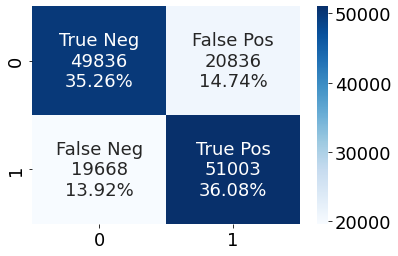

In [ ]:
y_lgb_Sel = rf_grid_best_Sel.predict(X_test_S)
cf_grid_Sel = confusion_matrix(y_test_S, y_lgb_Sel)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in cf_grid_Sel.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_grid_Sel.flatten()/np.sum(cf_grid_Sel)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_grid_Sel, annot=labels, fmt='', cmap='Blues')


In [ ]:
predictions_grid_Sel = rf_grid_best_Sel.predict_proba(test_selected)[:, 1]

In [ ]:
# Make a submission dataframe
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = predictions_grid_Sel
submit.to_csv('random_forest_GridSearch_baseline_Selected.csv', index=False)
joblib.dump(submit, 'random_forest_GridSearch_baseline_Selected.pkl')

['random_forest_GridSearch_baseline_Selected.pkl']

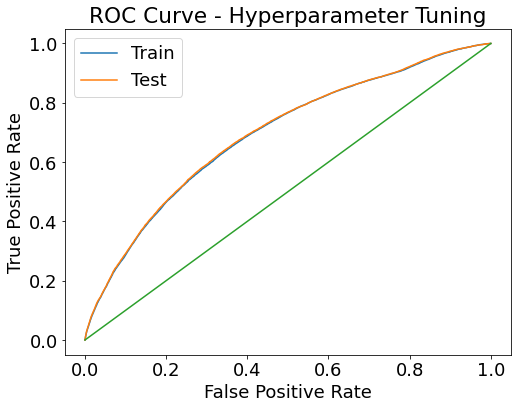

In [ ]:
#Tuning - Grid Search 


prob_train = rf_grid_best_Sel.predict_proba(X_train_scaled_Sel)
prob_test = rf_grid_best_Sel.predict_proba(X_test_scaled_Sel)

# Create train and test curve
fpr_train, tpr_train, thresh_train = roc_curve(y_train_S, prob_train[:, 1])
fpr_test, tpr_test, thresh_test = roc_curve(y_test_S, prob_test[:, 1])

# Create the straight line (how the graph looks like if the model does random guess instead)
random_probs = [0 for i in range(len(y_test_S))]
p_fpr, p_tpr, _ = roc_curve(y_test_S, random_probs)

# Plot the model
plt.figure(figsize=(8, 6))
plt.title('ROC Curve - Hyperparameter Tuning')
plt.plot(fpr_train, tpr_train, label='Train')
plt.plot(fpr_test, tpr_test, label='Test')
plt.plot(p_fpr, p_tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

In [ ]:
X_test_S.head()

,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_LAST_PHONE_CHANGE,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,...,AMT_REQ_CREDIT_BUREAU_QRT,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,AMT_REQ_CREDIT_BUREAU_MON,FLAG_PHONE,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Academic degree,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary
291276,-0.114908,1.857680,1.583889,-0.253230,0.199769,0.439188,1.117719,-1.618216,-1.407271,-1.365893,...,-0.327323,2,2,-0.271638,1,1,0,0,0,0
131339,1.241909,1.907090,2.067459,-0.291449,0.199769,-0.061226,1.117719,-0.710731,-0.860818,-0.843791,...,-0.327323,2,2,-0.271638,0,1,0,0,0,0
287023,0.327853,-2.382482,-1.062569,1.544407,0.741723,1.322272,0.512251,0.353513,-0.156163,-0.191163,...,-0.327323,2,2,-0.271638,0,1,0,0,0,0
130090,-1.417840,-1.667305,-0.465735,-1.026846,0.167383,-0.565428,-2.497579,-0.335700,-0.939325,-0.843791,...,-0.327323,3,3,-0.271638,0,1,0,0,0,0
283482,0.581186,0.704023,1.409369,-0.759968,0.246323,-2.459832,-1.215336,-1.461126,-1.264770,-1.235368,...,-0.327323,2,2,-0.271638,1,1,0,0,0,0


## Recall, Precision, Accuracy, roc curve, auc

In [ ]:
y_lr_Sel = log_reg_Sel.predict(X_test_S)
y_rndm_Sel = random_forest_Sel.predict(X_test_S)
y_lgb_Sel = model_Sel.predict(X_test_S)
y_hytune_Sel = rf_grid_best_Sel.predict(X_test_S)

from sklearn.metrics import accuracy_score
print("ACCURACY")
print("Logistic Regression : ", accuracy_score(y_test_S, y_lr_Sel))
print("Random Forest : ", accuracy_score(y_test_S, y_rndm_Sel))
print("Light GBM : ", accuracy_score(y_test_S, y_lgb_Sel))
print("Hyperparameter Tuning : ", accuracy_score(y_test_S, y_hytune_Sel))

from sklearn.metrics import precision_score
print("Precision")
print("Logistic Regression : ", precision_score(y_test_S, y_lr_Sel, average='macro'))
print("Random Forest : ", precision_score(y_test_S, y_rndm_Sel, average='macro'))
print("Light GBM : ", precision_score(y_test_S, y_lgb_Sel, average='macro'))
print("Hyperparameter Tuning : ", precision_score(y_test_S, y_hytune_Sel, average='macro'))

from sklearn.metrics import recall_score
print("Recall")
print("Logistic Regression : ", recall_score(y_test_S, y_lr_Sel, average='macro'))
print("Random Forest : ", recall_score(y_test_S, y_rndm_Sel, average='macro'))
print("Light GBM : ", recall_score(y_test_S, y_lgb_Sel, average='macro'))
print("Hyperparameter Tuning : ", recall_score(y_test_S, y_hytune_Sel, average='macro'))

from sklearn.metrics import roc_curve, auc
print("ROC Curve, AUC")
fpr, tpr, thresholds = roc_curve(y_test_S, y_lr_Sel, pos_label=1)  # pos_label: positive label
print("Logistic Regression : ", auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y_test_S, y_rndm_Sel, pos_label=1) # pos_label: positive label
print("Random Forest : ", auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y_test_S, y_lgb_Sel, pos_label=1) # pos_label: positive label
print("Light GBM : ", auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y_test_S, y_hytune_Sel, pos_label=1) # pos_label: positive label
print("Hyperparameter Tuning : ", auc(fpr, tpr))
from sklearn.metrics import f1_score
print("f1_score")
print("Logistic Regression : ", f1_score(y_test_S, y_lr_Sel, average='macro'))
print("Random Forest : ", f1_score(y_test_S, y_rndm_Sel, average='macro'))
print("Light GBM : ", f1_score(y_test_S, y_lgb_Sel, average='macro'))
print("Hyperparameter Tuning : ", f1_score(y_test_S, y_hytune_Sel, average='macro'))
